In [69]:
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import category
import seaborn as sns
from sklearn.preprocessing import LabelEncoder as le
from sklearn.calibration import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

In [70]:

#File path
file_path = "/Users/patry/Retail Store Inventory Forecasting Dataset/TimeSeriesForecasting/data/retail_store_inventory.csv"
#Read the data
data = pd.read_csv(file_path)
# Basic data info

print(data.head())
print("Statistics of the data\n")
print(data.info())
print("Search for missing values\n")
print(data.isna().sum())

         Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001    Groceries  North              231   
1  2022-01-01     S001      P0002         Toys  South              204   
2  2022-01-01     S001      P0003         Toys   West              102   
3  2022-01-01     S001      P0004         Toys  North              469   
4  2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51            74.02  27.99        10   
3          61            164            62.18  32.72        10   
4          14            135             9.26  73.64         0   

  Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  
0             Rainy                  0               29.69      Autumn  
1           

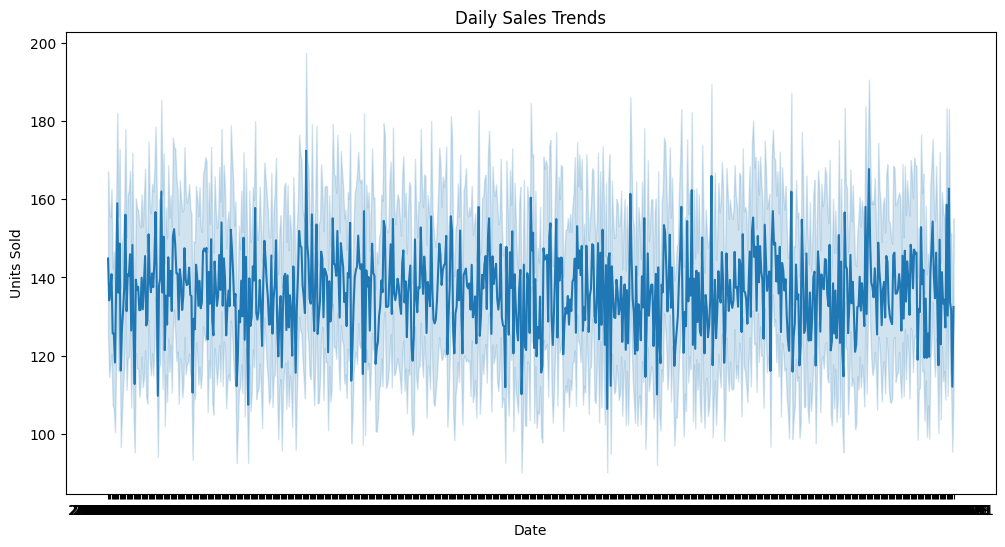

In [71]:
# Plot sales trends
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Units Sold', data=data)
plt.title('Daily Sales Trends')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

                                Date  Inventory Level    Units Sold  \
count                          73100     73100.000000  73100.000000   
mean   2022-12-31 23:59:59.999999744       274.469877    136.464870   
min              2022-01-01 00:00:00        50.000000      0.000000   
25%              2022-07-02 00:00:00       162.000000     49.000000   
50%              2023-01-01 00:00:00       273.000000    107.000000   
75%              2023-07-03 00:00:00       387.000000    203.000000   
max              2024-01-01 00:00:00       500.000000    499.000000   
std                              NaN       129.949514    108.919406   

       Units Ordered  Demand Forecast         Price      Discount  \
count   73100.000000     73100.000000  73100.000000  73100.000000   
mean      110.004473       141.494720     55.135108     10.009508   
min        20.000000        -9.990000     10.000000      0.000000   
25%        65.000000        53.670000     32.650000      5.000000   
50%       110.0

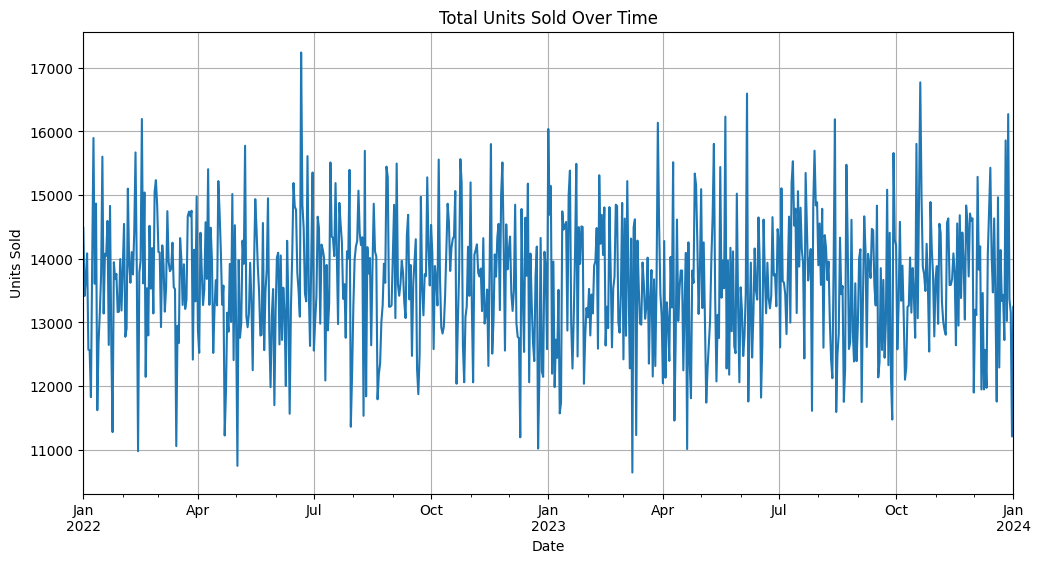

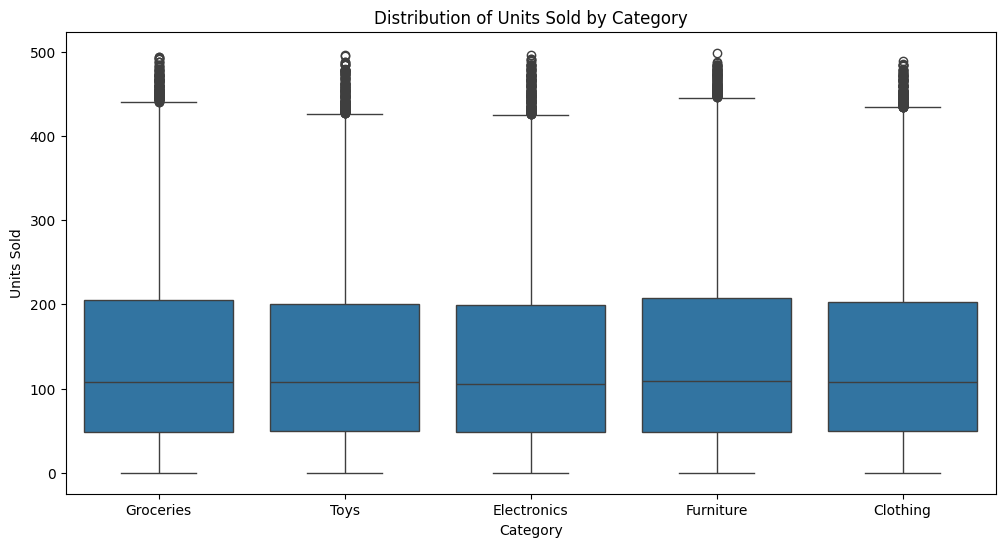

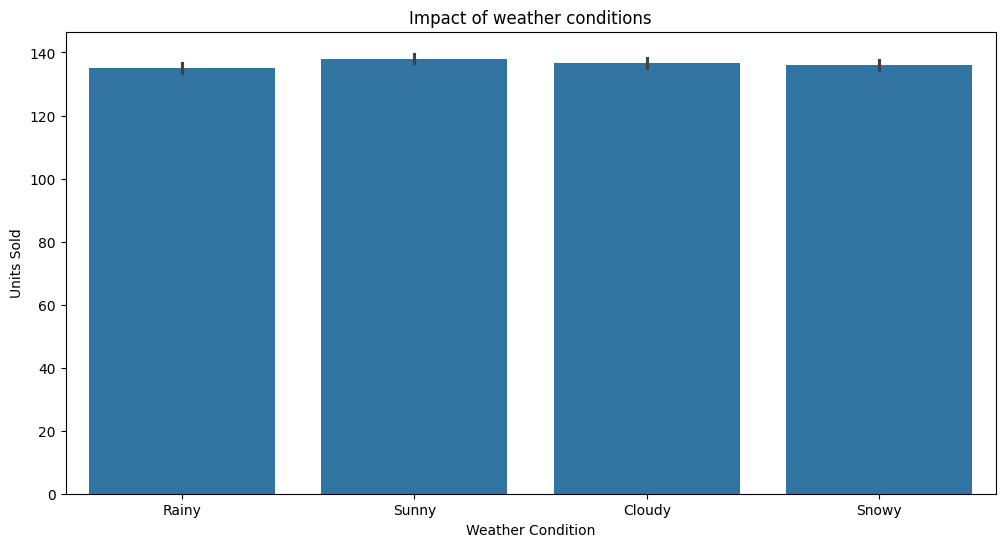

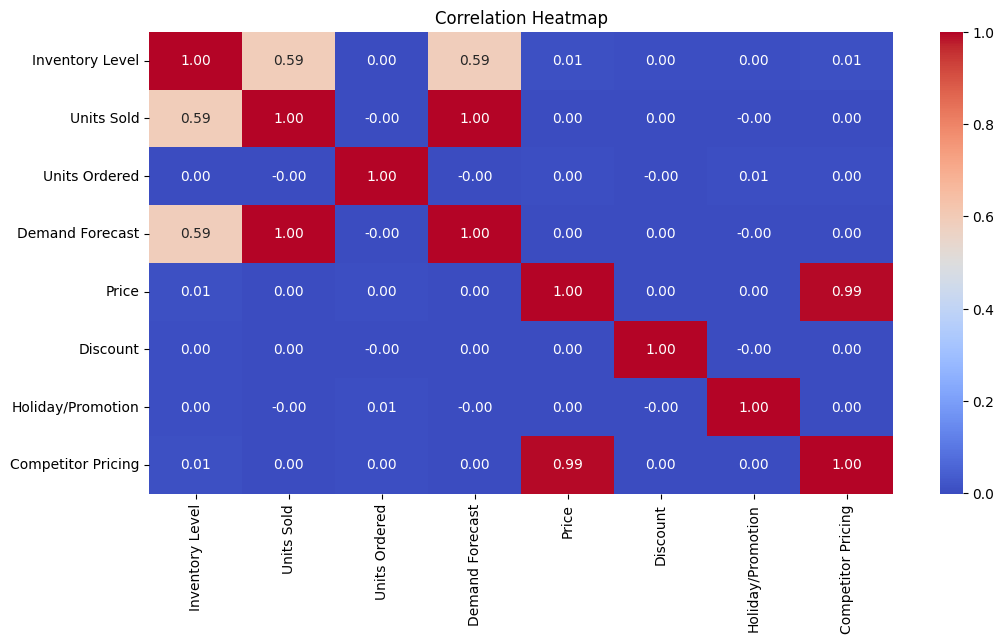

In [72]:
# Convert Date column to datetime
data["Date"] = pd.to_datetime(data["Date"])

# Check basic statistics of numeral features
print(data.describe())

# Plot total units sold over time
plt.figure(figsize=(12, 6))
data.groupby('Date')['Units Sold'].sum().plot()
plt.title('Total Units Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.grid()
plt.show()

# Boxplot: Units sold over time
plt.figure(figsize=(12,6))
sns.boxplot(x= "Category", y = "Units Sold", data=data)
plt.title("Distribution of Units Sold by Category")
plt.show()

# Barplot: Impact of Weather on Units Sold
plt.figure(figsize=(12,6))
sns.barplot(data= data,x="Weather Condition", y= "Units Sold")
plt.title("Impact of weather conditions")
plt.show()

# Correlation heatmap
numeric_columns = data.select_dtypes(include=["number"])

plt.figure(figsize=(12,6))
sns.heatmap(numeric_columns.corr(), annot= True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Total Units sold over time
- The time series shows significant daily variability in total units sold
- There seems to be reccuring peaks and troughs, possiblities reflecting seasonality or promotions

Distribution of Units sold by category
- The meidan of sold units in each category is consistant across categories
- There are outliers in every category, indicationg occasionial high demand for certain products

Impact of weather on units sold
- There are almost no differences between a different weather conditions
- The small variation suggests weather may be a weak predictor for this datase

Correlation heatmap
- Inventory level and units sold are positively correlated (0.59), suggesting stock availability influences sales
- Price and Competitor pricing are highly correlated (0.99), which migt indicate pricing strategies closely follow competitors
- Demand forecast is strongly correlated with units sold (1.00), which makes sence since it's likely derived from past trends



In [73]:
#Feature  enginieering

# Lagged features



data["lag_1"] = data["Units Sold"].shift(1)
data["lag_7"] = data["Units Sold"].shift(7)

# Rolling averages
data["rolling_avg_7"] = data["Units Sold"].rolling(window=7).mean()
data["rolling_avg_30"] = data["Units Sold"].rolling(window=30).mean()

# Date-based features

data['day'] = data["Date"].dt.day
data['month'] = data["Date"].dt.month
data['day_of_week'] = data["Date"].dt.dayofweek

# Encoding categorical variables

le_category = LabelEncoder()
data['Category_encoded'] = le_category.fit_transform(data['Category'])

le_region = LabelEncoder()
data['Region_encoded'] = le_region.fit_transform(data['Region'])

le_weather = LabelEncoder() 
data['Weather_encoded'] = le_weather.fit_transform(data['Weather Condition'])

le_seasonality = LabelEncoder()
data['Seasonality_encoded'] = le_seasonality.fit_transform(data['Seasonality'])

# Droping NA values generated by shifts and rolling windows

data = data.dropna()

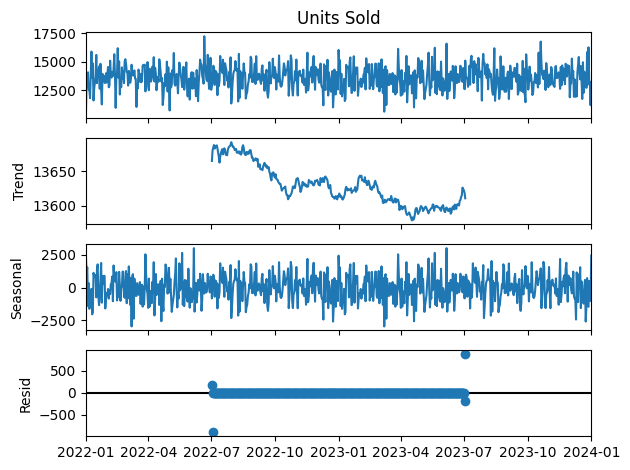

In [74]:
# Seasonal decomposition

# Grouping data to sum units sold across all stores and product per day
daily_sales = data.groupby("Date")["Units Sold"].sum()

# Decomposing time series
result = seasonal_decompose(daily_sales, model="additive", period=365)

# Plot the decomposition
result.plot()
plt.show()

## Conclusions


Trend - Captures the overall direction of the time siries over time
- There is a gradual decline in sales during 2023, which stabilizes towards the end of the year
- This could reflect market changes, reduced demand or external challenges
--Next step: Investigate potential causes of declining trend

Seasonal - it shows reapeating patterns at a periodic intervals
- There is a clear reapeating seasonal effect, possibly tied to weekly, montly or yearly changes
- Peaks and troughs might alligh with weekends, hollidays or seasonal shopping habits
--Next step: analyze specific dates to confirm if peaks coincide with holidays, promotions or seasonal demand

Residual (noise) - it represents remaining variability after removing trend and seasonality
- Large peaks in the beginning and at the end indicate outliears or events not explained by trend or seasonability
- These could be enexpected spikes or data errors
--Next step: Investigate the dates with large residuals to determine their cause

### Trend analysys by region and category


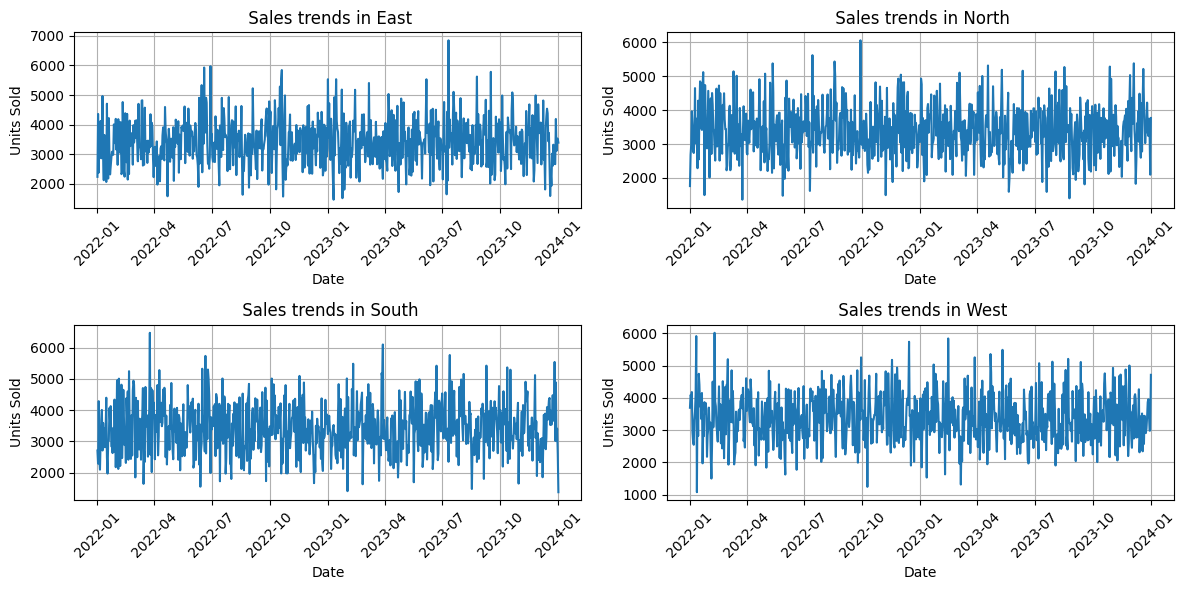

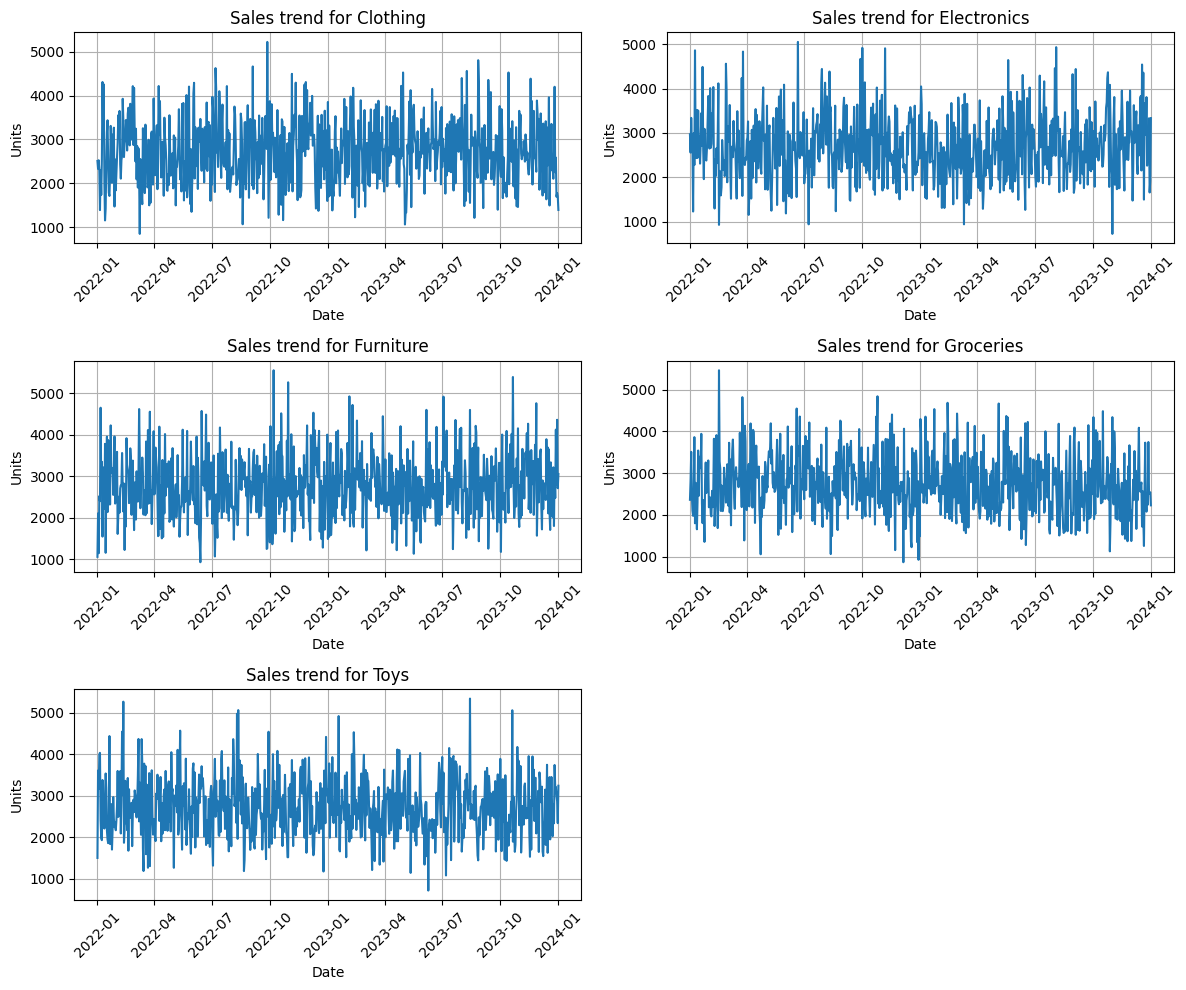

In [75]:
# Trend analysys by region and category

trend_by_region = data.groupby(['Date', 'Region'])['Units Sold'].sum().reset_index()
trend_by_category = data.groupby(['Date', 'Category'])['Units Sold'].sum().reset_index()

# Visialize trends by Region and Category by separating trend by region usung subplots
region = trend_by_region["Region"].unique()
plt.figure(figsize=(12,6))
for i, region in enumerate(region, 1):
    plt.subplot(2,2,i)
    region_data = trend_by_region[trend_by_region["Region"] == region]
    plt.plot(region_data["Date"], region_data["Units Sold"], label= region)
    plt.title(f" Sales trends in {region}")
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.xticks(rotation=45)
    plt.grid()
plt.tight_layout()
plt.show()

# Trend separation by category

categories = trend_by_category["Category"].unique()
plt.figure(figsize=(12,10))
for i, category in enumerate(categories, 1):
    plt.subplot(3, 2, i)
    category_data = trend_by_category[trend_by_category["Category"] == category]
    plt.plot(category_data["Date"], category_data["Units Sold"], label = category)
    plt.title(f"Sales trend for {category}")
    plt.xlabel("Date")
    plt.ylabel("Units")
    plt.xticks(rotation = 45)
    plt.grid()
plt.tight_layout()
plt.show()

### Observations

### Seasonal peaks and troughs analysis


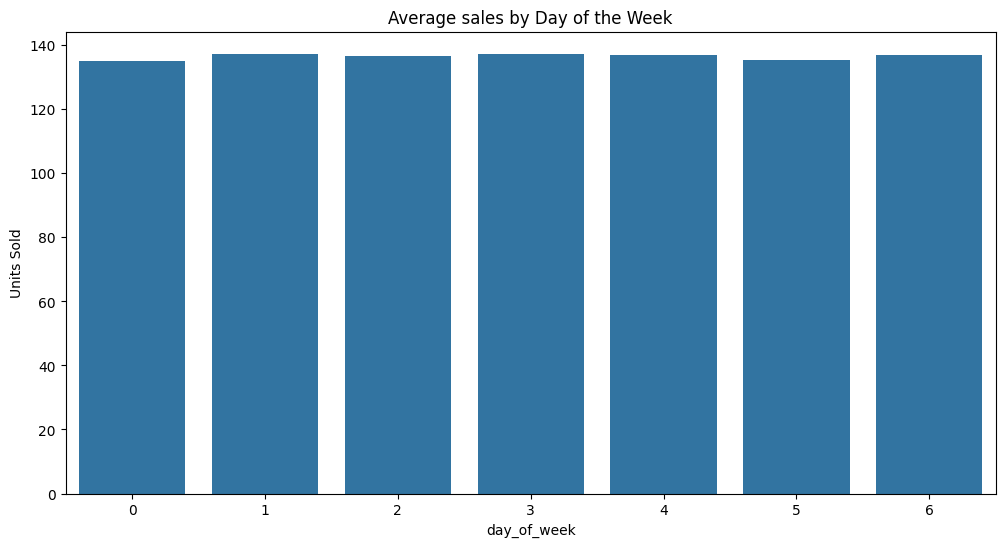

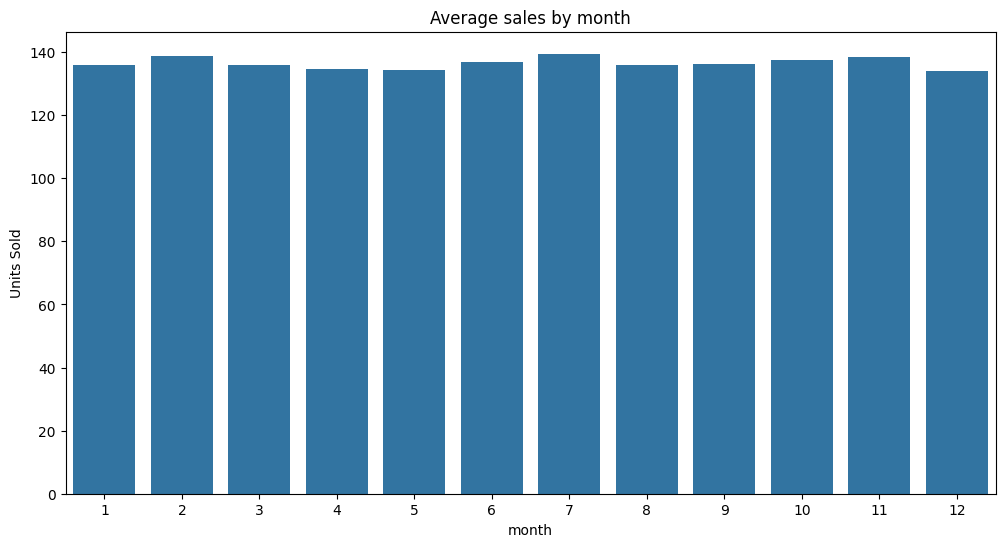

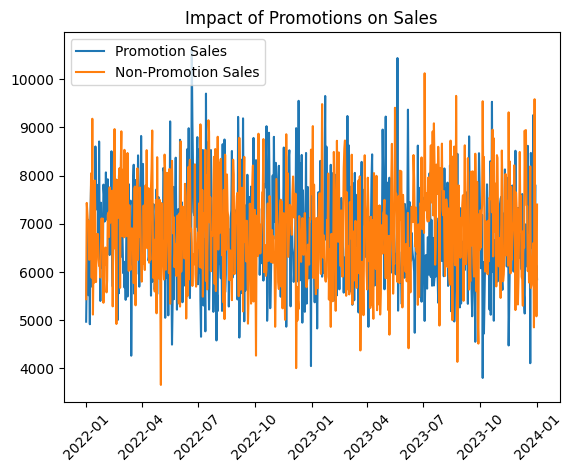

In [76]:
# Seasonal peaks and troughs analysis

sales_by_weekday = data.groupby("day_of_week")["Units Sold"].mean() 
plt.figure(figsize=(12,6))
sns.barplot(data=sales_by_weekday)
plt.title("Average sales by Day of the Week")
plt.show()

# Sales by month
sales_by_month = data.groupby("month")["Units Sold"].mean() 
plt.figure(figsize=(12,6))
sns.barplot(data=sales_by_month)
plt.title("Average sales by month")
plt.show()

# Promotion and Holiday Impact
promotion_sales = data[data['Holiday/Promotion'] == 1].groupby('Date')['Units Sold'].sum()
non_promotion_sales = data[data['Holiday/Promotion'] == 0].groupby('Date')['Units Sold'].sum()
plt.plot(promotion_sales.index, promotion_sales, label='Promotion Sales')
plt.plot(non_promotion_sales.index, non_promotion_sales, label='Non-Promotion Sales')
plt.legend()
plt.xticks(rotation =45)
plt.title('Impact of Promotions on Sales')
plt.show()

### Conclusions
Day of week is not a strong factor for demand forecasting, sales are remarkably consistent across all days of the week.

Seasonality by mont may not be a major driver of variability. 

Promotions appear to have a moderate effect but are not a consistently dominant drier of sales increases.


## Residual analysis

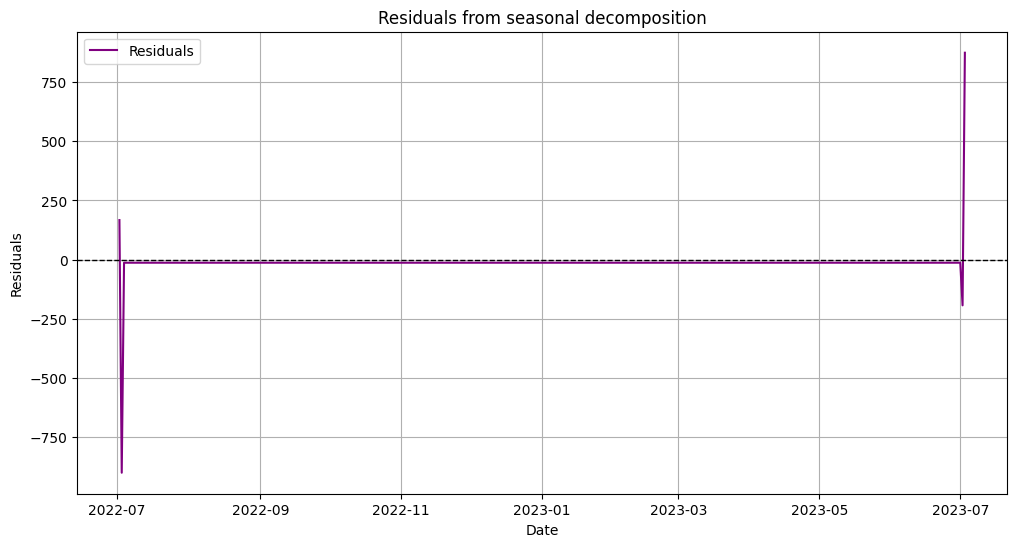

In [77]:
# Plotting residuals from seasonal decomposition
from turtle import color


plt.figure(figsize=(12,6))
plt.plot(result.resid, label= "Residuals", color = "purple")
plt.axhline(y=0, color="black", linestyle="--", linewidth=1)
plt.title("Residuals from seasonal decomposition")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid()
plt.legend()
plt.show()


### Conclusions
There are large spikes in four days 2022-07-02, 2022-07-03, 2023-07-02, 2023-07-03 it can be explained by special event occuring every single year.
Those dates are going to be replaced for the modeling because they can skew the model.


## Identify outliers

In [78]:
# Calcitaling the threshold for outliers
residuals = result.resid.dropna()
mean_resid = residuals.mean()
std_resid = residuals.std()
upper_threshold = mean_resid + 2 * std_resid
lower_threshold = mean_resid - 2 * std_resid

# Identifying dates with large residuals
outlier_dates = residuals[(residuals > upper_threshold) | (residuals < lower_threshold)]

# Print outliers dates
print(f"Outliers dates with large residuals: {outlier_dates}\n")

# Filter data for outlier dates
outlier_data = data[data["Date"].isin(outlier_dates.index)]

# Display outlier details
print(outlier_data[['Date', 'Units Sold', 'Holiday/Promotion', 'Weather Condition', 'Competitor Pricing']])

Outliers dates with large residuals: Date
2022-07-02    167.211574
2022-07-03   -899.345960
2023-07-02   -192.703494
2023-07-03    873.854040
Name: resid, dtype: float64

            Date  Units Sold  Holiday/Promotion Weather Condition  \
18200 2022-07-02           8                  0            Cloudy   
18201 2022-07-02          62                  1             Sunny   
18202 2022-07-02         190                  0             Rainy   
18203 2022-07-02         210                  0             Sunny   
18204 2022-07-02         201                  0             Sunny   
...          ...         ...                ...               ...   
54895 2023-07-03         274                  1             Rainy   
54896 2023-07-03         367                  0            Cloudy   
54897 2023-07-03         256                  0             Snowy   
54898 2023-07-03         347                  0             Sunny   
54899 2023-07-03          56                  0            Cloudy   



In [79]:
# Calculate the global mean of Units Sold
global_mean = data["Units Sold"].mean()
cleaned_data = data.copy()

# Replace the outliers with global mean
for date in outlier_dates.index:
    cleaned_data.loc[cleaned_data["Date"] == date, "Units Sold"] = global_mean
# Checking for NaN
print(cleaned_data.isna().sum())

Date                   0
Store ID               0
Product ID             0
Category               0
Region                 0
Inventory Level        0
Units Sold             0
Units Ordered          0
Demand Forecast        0
Price                  0
Discount               0
Weather Condition      0
Holiday/Promotion      0
Competitor Pricing     0
Seasonality            0
lag_1                  0
lag_7                  0
rolling_avg_7          0
rolling_avg_30         0
day                    0
month                  0
day_of_week            0
Category_encoded       0
Region_encoded         0
Weather_encoded        0
Seasonality_encoded    0
dtype: int64


/var/folders/fl/m9y18vxd24lf1tgmyqxdp0sh0000gn/T/ipykernel_13673/1112920121.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '136.4630701646344' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cleaned_data.loc[cleaned_data["Date"] == date, "Units Sold"] = global_mean


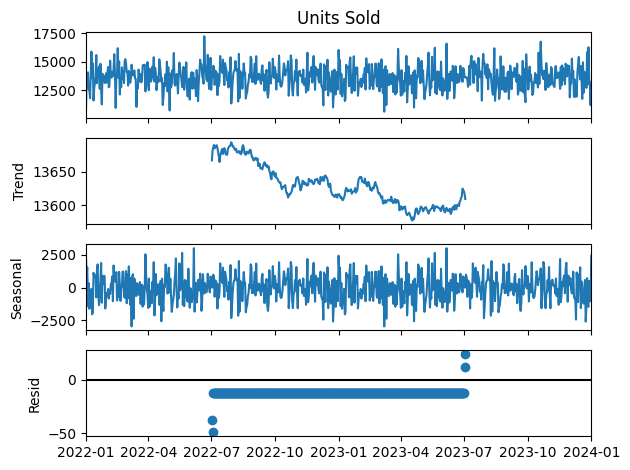

In [80]:
# Seasonal decomposition after data cleaning
cleaned_daily_sales = cleaned_data.groupby("Date")["Units Sold"].sum()

# Decomposing time series
result = seasonal_decompose(cleaned_daily_sales, model="additive", period=365)

# Plot the decomposition
result.plot()
plt.show()

### Conclusions
Replacing outliers with the global mean value of a units sold shrinken the variability in the residuals. Unfortunately it shifted main line of residuals. Let's focus on residuals once more and check for the normal distribution and there is no autocorrelations.

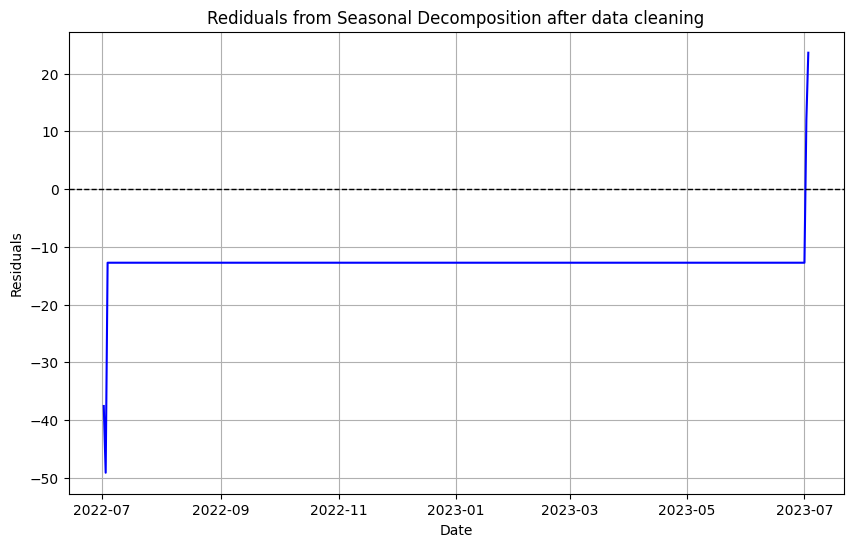

In [81]:
# Visualise residuals
plt.figure(figsize=(10,6))
plt.plot(result.resid, label= "Residuals", color= "blue")
plt.axhline(y= 0, color = "black", linestyle= "--", linewidth= 1)
plt.title("Rediduals from Seasonal Decomposition after data cleaning")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid()
plt.show()

In [82]:
# Calculate mean and variance of residuals
residuals = result.resid.dropna()
mean_resid = residuals.mean()
var_resid = residuals.var()
print(f'Mean of residuals{mean_resid:.2f}')
print(f'Variance of residuals{var_resid:.2f}')

Mean of residuals-12.75
Variance of residuals10.60


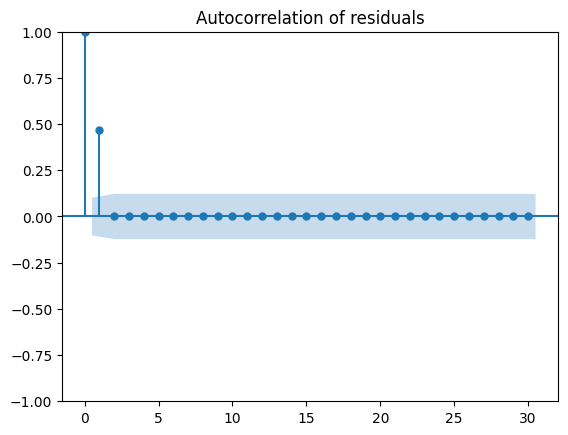

Ljung-Box test results
      lb_stat     lb_pvalue
10  80.198812  4.589563e-13


In [83]:
# Autocorrelation plot
plot_acf(residuals, lags=30)
plt.title('Autocorrelation of residuals')
plt.show()

#Ljung-Box test
ljung_box = acorr_ljungbox(residuals, lags=[10], return_df= True)
print("Ljung-Box test results")
print(ljung_box)

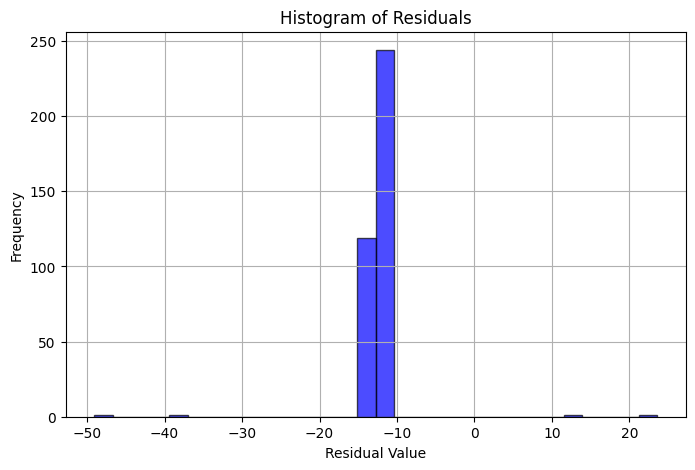

Shapiro-Wilk Test: Statistic=0.092, p-value=0.000
D'Agostino Test: Statistic=173.348, p-value=0.000


In [84]:
from scipy.stats import shapiro, normaltest

# Histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Shapiro-Wilk test
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic:.3f}, p-value={shapiro_test.pvalue:.3f}")

# D'Agostino's K-squared test
dagostino_test = normaltest(residuals)
print(f"D'Agostino Test: Statistic={dagostino_test.statistic:.3f}, p-value={dagostino_test.pvalue:.3f}")

In [85]:
# Data preparation for modelling

# Agregation of daily sales

daily_sales = cleaned_data.groupby("Date")["Units Sold"].sum().reset_index()

# Chcecking for missing dates and filling them if necesseary
date_range_fixed = pd.date_range(start=daily_sales['Date'].min(), end=daily_sales['Date'].max())  # Ensure no naming conflict

# Reindexing to ensure all dates are present, filling missing values with 0
daily_sales = daily_sales.set_index('Date').reindex(date_range_fixed).fillna(0).reset_index()
daily_sales.columns = ['Date', 'Units Sold']

# Split into training and test set
train, test = train_test_split(daily_sales, test_size=0.25, shuffle=False)

ARIMA MAE: 839.2159862461382


/Users/patry/opt/anaconda3/envs/PredictingRetails/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


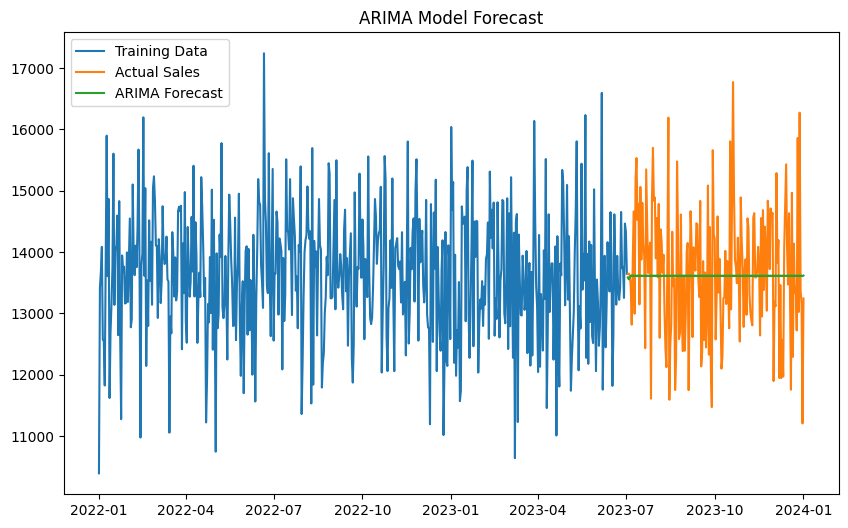

In [86]:

# Fit ARIMA model (manually choosing p, d, q or tune using grid search)
model = ARIMA(train['Units Sold'], order=(5, 1, 2))  # Example (p, d, q)
arima_result = model.fit()

# Forecast on the test set
forecast = arima_result.forecast(steps=len(test))
test['ARIMA Forecast'] = forecast.values

# Evaluate performance
mae_arima = mean_absolute_error(test['Units Sold'], test['ARIMA Forecast'])
print(f"ARIMA MAE: {mae_arima}")

# Plot the results

plt.figure(figsize=(10, 6))
plt.plot(train['Date'], train['Units Sold'], label='Training Data')
plt.plot(test['Date'], test['Units Sold'], label='Actual Sales')
plt.plot(test['Date'], test['ARIMA Forecast'], label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.show()

16:07:47 - cmdstanpy - INFO - Chain [1] start processing
16:07:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 879.0164874056863


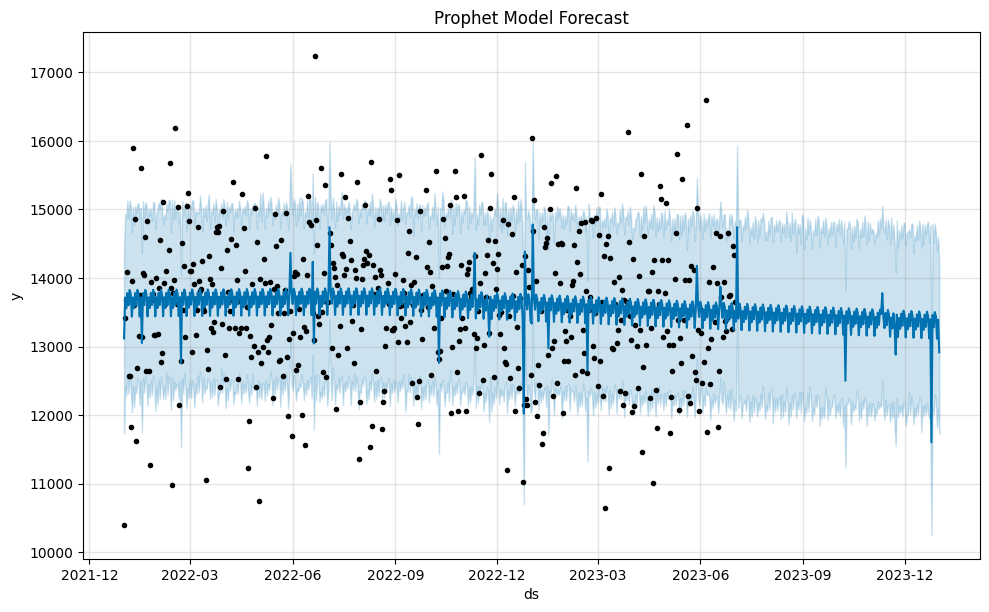

In [87]:
from prophet import Prophet

# Prepare data for Prophet
prophet_data = daily_sales.rename(columns={'Date': 'ds', 'Units Sold': 'y'})

# Fit Prophet model
model_prophet = Prophet()
model_prophet.add_country_holidays(country_name='US')  # Adjust for relevant country
model_prophet.fit(prophet_data[:-len(test)])  # Train on the training set

# Forecast
future = model_prophet.make_future_dataframe(periods=len(test))
forecast = model_prophet.predict(future)

# Extract relevant forecast for the test period
prophet_forecast = forecast[['ds', 'yhat']].iloc[-len(test):]
test['Prophet Forecast'] = prophet_forecast['yhat'].values

# Evaluate performance
mae_prophet = mean_absolute_error(test['Units Sold'], test['Prophet Forecast'])
print(f"Prophet MAE: {mae_prophet}")

# Plot the results
model_prophet.plot(forecast)
plt.title('Prophet Model Forecast')
plt.show()

### Conclusions
Arima model predicst constant line for prognose - green line. Which shows the model doesn't use trend and seasonality fully.

The prophet holds better with general trend and variablility of the data. Model generates confidence interval, which is usefull in buissness analytics.
